# BINARY ROAD SEGMENTATION USING UNET ARCHITECTURE

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm

## LOADING DATASET

In [ ]:
# LOADING IMAGE PATHS
IMG_DIR = "/content/drive/MyDrive/AVERERA/Images/"
MASK_DIR= "/content/drive/MyDrive/AVERERA/labels/"

imgdir = os.listdir(IMG_DIR)
maskdir = os.listdir(MASK_DIR)

# SORTING TO MAKE IMAGES AND MASKS CONSISTENT
imgdir.sort()
maskdir.sort()

len(imgdir),len(maskdir)

(701, 701)

## IMAGE PREPROCESSING

In [ ]:
# MASKS ARE MULTI CLASS SO CONVERTING THEM TO BINARY i.e. 0 - NOT A ROAD AND 1 - ROAD
def colorfull(image):
    width = 224
    height = 224
 
    # LOOP OVER THE IMAGE, PIXEL BY PIXEL
    for x in range(width):
        for y in range(height):
            b, g, r = frame[x, y]
            if (b, g, r) == (0,0,0): # BACKGROUND
                frame[x, y] = (0,0,0)
            else:
                frame[x,y] = (85,85,255)

    return image

In [ ]:
x=[] #IMAGES
for m, id__ in tqdm(enumerate(imgdir), total=len(imgdir)):   
    path = IMG_DIR + id__
    img1 = cv2.imread(path)
    img1 = cv2.resize(img1,(224,224))
    img1 = img1/255
    x.append(img1)

100%|██████████| 701/701 [00:12<00:00, 56.34it/s]


In [ ]:
y = [] #MASKS
from tqdm import tqdm
for img in tqdm(maskdir):
    pat = MASK_DIR + img
    frame = cv2.imread(pat)
    frame = cv2.resize(frame, (224,224))
    frame =  colorfull(frame)
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    frame = frame/136
    y.append(frame)

100%|██████████| 701/701 [04:29<00:00,  2.60it/s]


In [ ]:
# SPLITTING THE DATA INTO TRAIN AND TEST SETS
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2)

# CONVERTING THEM TO TENSORS
xtrain = tf.constant(np.array(xtrain))
ytrain = tf.constant(np.array(ytrain))
xtest = tf.constant(np.array(xtest))
ytest = tf.constant(np.array(ytest))

xtrain.shape,ytrain.shape,xtest.shape,ytest.shape

(TensorShape([560, 224, 224, 3]),
 TensorShape([560, 224, 224]),
 TensorShape([141, 224, 224, 3]),
 TensorShape([141, 224, 224]))

## VISUALISING IMAGES

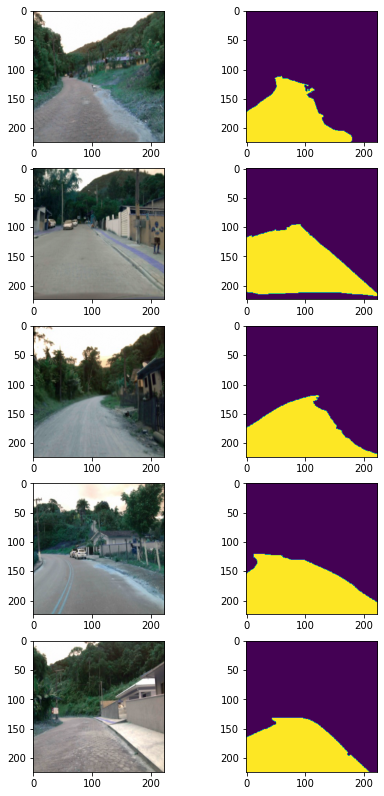

In [ ]:
l = [114,27,192,128,420]
fig,ax = plt.subplots(nrows = 5,ncols=2,figsize=(7,14))
for i in range(0,5):
    ax[i][0].imshow(xtrain[l[i]])
    ax[i][1].imshow(ytrain[l[i]])


## DEFINING MODEL

In [2]:
import tensorflow as tf
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    p = tf.keras.layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    # Upsample
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # Concatenate
    x = tf.keras.layers.concatenate([x, conv_features])
    # Dropout
    x = tf.keras.layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

def build_unet_model():
 # inputs
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

In [ ]:
unet_model = build_unet_model()
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 224, 224, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_58 (Conv2D)             (None, 224, 224, 64  36928       ['conv2d_57[0][0]']              
                                )                                                             

## TRAINING

In [ ]:
results = unet_model.fit(xtrain, ytrain, 
                         validation_split=0.1, 
                         batch_size=16, 
                         epochs=50,
                    )

Epoch 1/50
32/32 [==============================] - 25s 719ms/step - loss: 0.5857 - accuracy: 0.6583 - val_loss: 0.4000 - val_accuracy: 0.7963
Epoch 2/50
32/32 [==============================] - 23s 710ms/step - loss: 0.4052 - accuracy: 0.7947 - val_loss: 0.3371 - val_accuracy: 0.8783
Epoch 3/50
32/32 [==============================] - 22s 697ms/step - loss: 0.2677 - accuracy: 0.8989 - val_loss: 0.2000 - val_accuracy: 0.9221
Epoch 4/50
32/32 [==============================] - 22s 692ms/step - loss: 0.1918 - accuracy: 0.9222 - val_loss: 0.1699 - val_accuracy: 0.9334
Epoch 5/50
32/32 [==============================] - 22s 699ms/step - loss: 0.1569 - accuracy: 0.9340 - val_loss: 0.1265 - val_accuracy: 0.9525
Epoch 6/50
32/32 [==============================] - 22s 696ms/step - loss: 0.1233 - accuracy: 0.9513 - val_loss: 0.1047 - val_accuracy: 0.9587
Epoch 7/50
32/32 [==============================] - 22s 697ms/step - loss: 0.1049 - accuracy: 0.9597 - val_loss: 0.0836 - val_accuracy: 0.9661

## SAVING MODEL

In [ ]:
# unet_model.save("/content/drive/MyDrive/AVERERA/Model")
# model2.h5 -> on complete dataset
unet_model.save_weights("/content/drive/MyDrive/AVERERA/Weights/model.h5")


In [8]:
loaded_model = build_unet_model()
loaded_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="binary_crossentropy",
                  metrics="accuracy")
loaded_model.load_weights("/content/drive/MyDrive/AVERERA/Weights/model.h5")

In [ ]:
yp = loaded_model.predict(xtest)

5/5 [==============================] - 2s 453ms/step


## PREDICTIONS

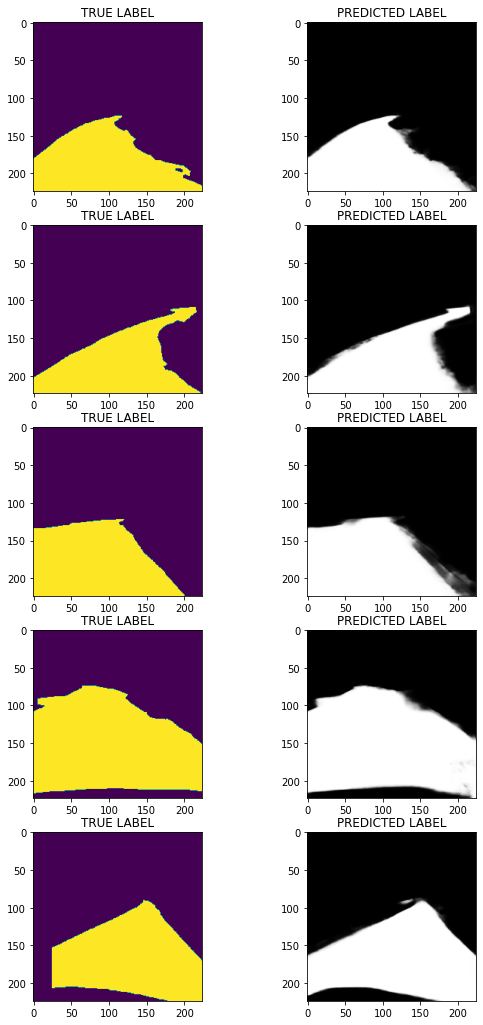

In [ ]:
l = [14,45,67,23,90]
fig,ax = plt.subplots(nrows = 5,ncols=2,figsize=(9,18))
for i in range(0,5):
    ax[i][0].imshow(ytest[l[i]])
    ax[i][0].set_title("TRUE LABEL")
    ax[i][1].imshow(np.squeeze(yp[l[i]]),cmap="gray")
    ax[i][1].set_title("PREDICTED LABEL")

## IIT BHU CAMPUS ROAD PREDICTIONS

In [9]:
def img_pred(path):
    li = []
    im = cv2.imread(path)
    im = cv2.resize(im,(224,224))
    im = tf.constant(im/255)
    li.append(im)
    li = np.array(li)
    loaded_model = build_unet_model()
    loaded_model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss="binary_crossentropy",
                      metrics="accuracy")
    loaded_model.load_weights("/content/drive/MyDrive/AVERERA/Weights/model.h5")
    ypr = loaded_model.predict(li)
    return np.squeeze(ypr)

1/1 [==============================] - 1s 1s/step


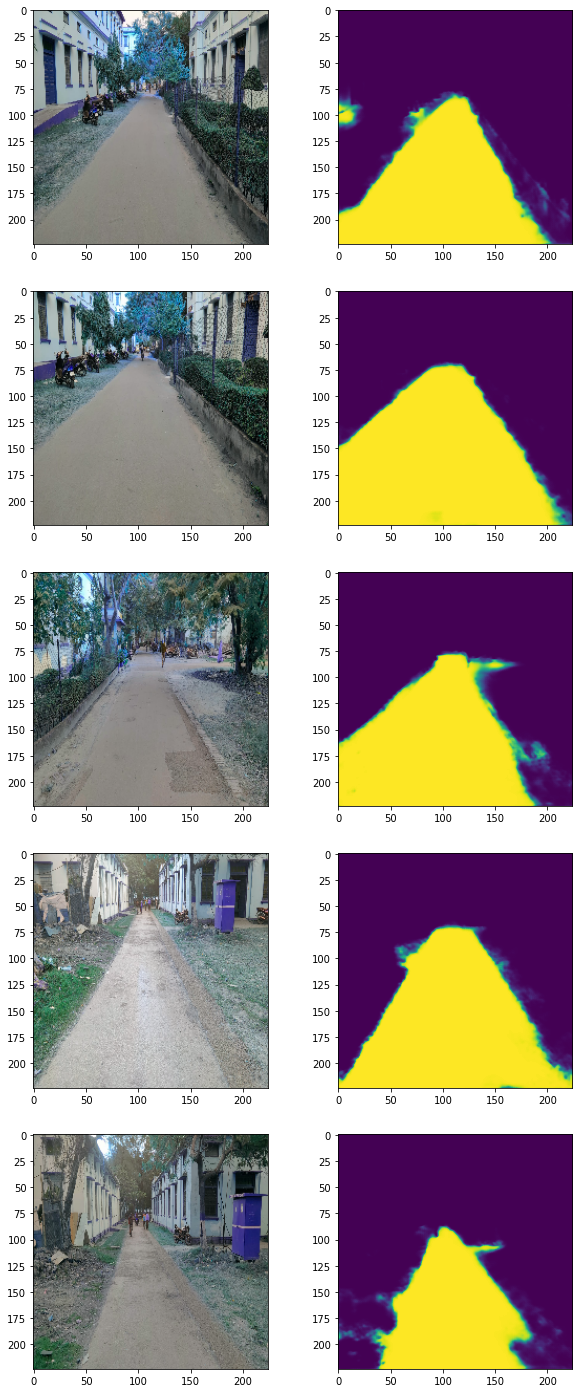

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5,2,figsize=(10,25))
for i in range(0,5):
    path = f"/content/drive/MyDrive/AVERERA/CAMPUS ROAD/PHOTOS/P{5-i}.jpeg"
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    ypred = img_pred(path)
    ax[i][0].imshow(img)
    ax[i][1].imshow(ypred)
